## Explaining Tree-based Models with TreeSHAP-IQ
This notebook showcases how we can use `shapiq` to explain the predictions of tree-based models.

For this example, we use the California housing dataset https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

### Imports

We will use `scikit-learn` to create machine learning models.

In [47]:
import shapiq

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

{v.__name__: v.__version__ for v in [shapiq, np, pd, matplotlib, sklearn]}

{'shapiq': '0.0.7',
 'numpy': '1.26.4',
 'pandas': '2.2.1',
 'matplotlib': '3.8.3',
 'sklearn': '1.4.1.post1'}

### Load data

California housing dataset considers a regression task to estimate median house value for households within a block (measured in 100k US Dollars). 

It has the following explanatory features:

1. **Longitude**: A measure of how far west a house is; a higher value is farther west.
2. **Latitude**: A measure of how far north a house is; a higher value is farther north.
3. **HouseAge**: Median age of a house within a block; a lower number is a newer building.
4. **AveRooms**: Average number of rooms within a block.
5. **AveBedrms**: Average number of bedrooms within a block.
6. **Population**: Total number of people residing within a block.
7. **MedInc**: Median income for households within a block of houses (measured in tens of thousands of US Dollars).
8. **AveOccup**: Average number of residing people per household within a block.

In [48]:
X, y = shapiq.load_california_housing()
X.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25


Visualize a distribution of the target feature.

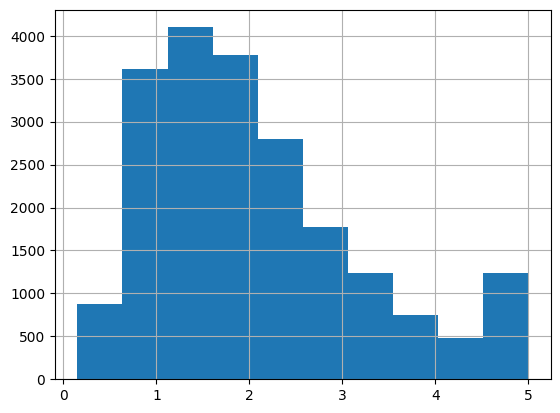

In [49]:
_ = y.hist()

Split the data into train and test subsets.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
n_features = X.shape[1]

### Models

We train two tree-based models: 
1. A decision tree with maximum tree depth of 10. It achieves $R^2=0.83$ on train set and $R^2=0.68$ on test set.
2. A random forest model of 100 decision trees with maximum tree depth of 8. It achieves $R^2=0.78$ on train set and $R^2=0.73$ on test set.

As expected, the random forest model is less overfitted and achieves better validation performance.

In [51]:
model_dt = DecisionTreeRegressor(max_depth=10, random_state=42)
model_dt.fit(X_train, y_train)
print(f'Train R2: {model_dt.score(X_train, y_train):.3f}')
print(f'Val R2: {model_dt.score(X_test, y_test):.3f}')

Train R2: 0.832
Val R2: 0.684


In [52]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=8, max_features="sqrt", random_state=42)
model_rf.fit(X_train, y_train)
print(f'Train R2: {model_rf.score(X_train, y_train):.3f}')
print(f'Val R2: {model_rf.score(X_test, y_test):.3f}')

Train R2: 0.779
Val R2: 0.733


### Explain feature interactions

Beyond predictive performance, we want to explain both models with TreeSHAP-IQ. 

First, create the `shapiq.Explainer` object that is an interface for explanation.

In [7]:
explainer_rf = shapiq.Explainer(model_rf)

`shapiq.Explainer` will automatically detect that the model is tree-based and create the `shapiq.TreeExplainer` object.

In [9]:
explainer_rf

We proceed in the same manner with the decision tree model.

In [11]:
explainer_dt = shapiq.Explainer(model_dt)

We want to explain price prediction for a new house.

In [12]:
small_house = pd.DataFrame({'medInc'})

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93
...,...,...,...,...,...,...,...,...
15316,1.3269,19.0,3.987578,1.153209,1190.0,2.463768,33.20,-117.36
14772,2.7361,14.0,4.206612,0.983471,1224.0,3.371901,32.57,-117.07
12870,3.8355,15.0,6.419753,1.039781,2626.0,3.602195,38.71,-121.40
13476,4.3958,10.0,6.154506,1.013948,3528.0,3.785408,34.09,-117.39


In [ ]:
id_observation = 0

In [ ]:
x = X_test[0]

In [ ]:
interaction_values_tabular = explainer_tabular.explain(x, budget=2**n_features)

In [ ]:
interaction_values_tree = explainer_tree.explain(x)

### visualize

In [ ]:
first_order_values = np.asarray([interaction_values_tabular[(i,)] for i in range(n_features)])
second_order_values = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        if i == j:
            continue
        second_order_values[i, j] = interaction_values_tabular[(i, j)]

In [ ]:
fig, axes = shapiq.network_plot(
    first_order_values=first_order_values,
    second_order_values=second_order_values,
    feature_names=data.drop("Count", axis=1).columns,
)
plt.tight_layout()
plt.show()

In [ ]:
first_order_values = np.asarray([interaction_values_tree[(i,)] for i in range(n_features)])
second_order_values = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        if i == j:
            continue
        second_order_values[i, j] = interaction_values_tree[(i, j)]

In [ ]:
fig, axes = shapiq.network_plot(
    first_order_values=first_order_values,
    second_order_values=second_order_values,
    feature_names=data.drop("Count", axis=1).columns,
)
plt.tight_layout()
plt.show()